<a href="https://colab.research.google.com/github/marketpsych/marketpsych/blob/main/notebooks/iv_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting the USD/JPY Rate with Media Sentiment

This notebook gives an example of how media sentiment can be used as a feature in a machine learning model for forecasting asset prices. In this example, we use the 1-week ahead USD/JPY spot rate change as a target. For features, we use price data (to represent the use of fundamental data) and the sentiment RMA from news and social media around the JPY.

---
## 1. Settings

### 1.1 Libraries
First, we need to install some libraries to obtain the Refinitiv MarketPsych Analytics (RMA) data directly into this notebook. If you need more details about downloading the data, please check out the [*i_introduction*](https://github.com/marketpsych/marketpsych/blob/main/notebooks/i_introduction.ipynb) notebook also provided on our [GitHub page](https://github.com/marketpsych/marketpsych).  

Additionally, some standard Python libraries are also necessary for running this example. If any of those libraries are not installed in your environment, please `pip install` them as:

```python
!{sys.executable} -m pip install libraryname
```

To install/load the libraries please run the following cell.

In [1]:
import sys
# Installs marketpsych's library into your environment
!{sys.executable} -m pip install marketpsych requests yfinance --upgrade --quiet
!{sys.executable} -m pip install tensorflow shap --quiet

import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import yfinance as yf

from dataclasses import dataclass
from marketpsych import sftp

### 1.2 Credentials

You need to provide your `userID` and ppk (or ssh) `key path` to access the RMA. Please adjust those two parameters in the below cell accordingly and then run the cell.

In [2]:
user = "8955490"
path_to_key = "./8955490.ppk"

# Creates client object to connect with MarketPsych data
client = sftp.connect(user=user, key=path_to_key)

### 1.3 Loading the data

#### 1.3.1 RMA
Now you're ready to download the RMA (Refinitiv MarketPsych Analytics) data.
In this example, we'll use the `JPY` RMAs from the currencies package. To simplify, we'll use the aggregated information from news and social media combined (`dataType == 'News_Social'`). As we are aiming at a rotating strategy with weekly turnover, the lowest frequency data (`WDAI_UDAI`), is suitable for the purpose of this example.

After running the cell below, you should see a snippet of the dataframe.

In [3]:
%%time
########## INPUTS ########
trial      = False
assetClass = 'CUR'
frequency  = 'WDAI_UDAI'
start_date = datetime.datetime(1998, 1, 1) #yyyy-mm-dd
end_date   = datetime.datetime(2022, 2, 28)
dataTypes  = ('News_Social',)
assetCodes = ('JPY',)

rma = client.download(
    trial       = trial,
    asset_class = sftp.AssetClass[assetClass],
    frequency   = sftp.Frequency[frequency],
    start       = start_date,
    end         = end_date,
    sources     = dataTypes,
    assets      = assetCodes
)
display(rma)

,id,assetCode,windowTimestamp,dataType,systemVersion,mentions,buzz,sentiment,negative,positive,...,priceDown,priceUp,priceForecast,priceMomentum,topVsBottom,overvaluedVsUndervalued,volatility,carryTrade,currencyPegInstability,futureVsPast
0,mp:1998-01-01_20.30.00.News_Social.CUR.JPY,JPY,1998-01-01 20:30:00+00:00,News_Social,MP:4.0.0,6.0,76.50,-0.026144,0.183007,0.156863,...,0.026144,0.039216,-0.026144,NaN,0.039216,NaN,0.013072,NaN,NaN,-0.124183
1,mp:1998-01-02_20.30.00.News_Social.CUR.JPY,JPY,1998-01-02 20:30:00+00:00,News_Social,MP:4.0.0,8.0,105.00,0.014286,0.195238,0.209524,...,0.028571,0.028571,-0.009524,NaN,0.009524,NaN,0.019048,NaN,NaN,0.171429
2,mp:1998-01-03_20.30.00.News_Social.CUR.JPY,JPY,1998-01-03 20:30:00+00:00,News_Social,MP:4.0.0,4.0,37.00,-0.027027,0.243243,0.216216,...,0.054054,0.027027,0.027027,NaN,NaN,NaN,NaN,NaN,NaN,-0.135135
3,mp:1998-01-04_20.30.00.News_Social.CUR.JPY,JPY,1998-01-04 20:30:00+00:00,News_Social,MP:4.0.0,4.0,36.00,-0.333333,0.361111,0.027778,...,0.055556,NaN,NaN,NaN,NaN,NaN,0.055556,NaN,NaN,-0.388889
4,mp:1998-01-05_20.30.00.News_Social.CUR.JPY,JPY,1998-01-05 20:30:00+00:00,News_Social,MP:4.0.0,23.0,297.00,-0.087542,0.250842,0.163300,...,0.033670,NaN,-0.023569,NaN,-0.021886,NaN,0.021886,NaN,NaN,0.292929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8819,mp:2022-02-23_20.30.00.News_Social.CUR.JPY,JPY,2022-02-23 20:30:00+00:00,News_Social,MP:4.0.13,374.0,1417.90,-0.002821,0.211581,0.208759,...,0.030327,0.042669,-0.000353,0.000000,0.006347,NaN,0.014105,0.002116,-0.000705,-0.402215
8820,mp:2022-02-24_20.30.00.News_Social.CUR.JPY,JPY,2022-02-24 20:30:00+00:00,News_Social,MP:4.0.13,796.0,4919.15,-0.029070,0.246791,0.217721,...,0.019719,0.035372,-0.000102,0.000610,-0.000610,-0.000407,0.030747,NaN,0.000203,-0.317382
8821,mp:2022-02-25_20.30.00.News_Social.CUR.JPY,JPY,2022-02-25 20:30:00+00:00,News_Social,MP:4.0.13,577.0,2496.95,-0.068884,0.241294,0.172410,...,0.040650,0.028835,-0.000400,0.001001,-0.000400,0.000000,0.029336,NaN,NaN,-0.422836
8822,mp:2022-02-26_20.30.00.News_Social.CUR.JPY,JPY,2022-02-26 20:30:00+00:00,News_Social,MP:4.0.13,148.0,515.00,-0.133010,0.276699,0.143689,...,0.066019,0.017476,0.000000,-0.001942,0.003883,NaN,0.029126,NaN,NaN,-0.338835


CPU times: user 6.5 s, sys: 143 ms, total: 6.65 s
Wall time: 31.2 s


#### 1.3.2 Price 

We will download price data from Yahoo Finance as it is easily available through the `yfinance` library (please adjust this according to your access to price data). As the strategy will be based on a weekly rotation at the Open on Mondays, we already download the weekly sampled data with the appropriate start date.

In [4]:
# Retrieves weekly price data from yfinance
price_df = yf.download("JPY=X", interval="1wk", start="1997-12-29", 
                       end="2022-02-27", progress=False)
# Replaces an incorrect price data point with a rough estimate
price_df.loc['2007-11-19', 'High'] = 111  # It had a >600 price
price_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-12-29,129.860001,132.600006,129.220001,132.199997,132.199997,0
1998-01-05,132.100006,134.399994,130.490005,131.520004,131.520004,0
1998-01-12,131.490005,133.100006,128.000000,128.770004,128.770004,0
1998-01-19,128.720001,129.779999,125.199997,125.419998,125.419998,0
1998-01-26,125.440002,127.750000,124.250000,126.419998,126.419998,0


## 2. Methodology 

### 2.1 Pairing the data

We will develop a strategy based on a weekly rotation. We choose the Monday opening as the entry/exit point. In order to determine what should be the the position (i.e., long or short), we will train a LSTM model to predict the 1-week ahead change in the JPY/USD rate.

The chosen features for the model are:
 - the log of the FX rate change in the previous week;
 - the volatility (proxied through the rate between the High and Low prices) in the previous week (see `calc_vol_hl` function below);
 - the buzz-weighted JPY sentiment in the previous week (Sunday to Sunday, see `buzz_weight_rmas` function and the following equation:

$\Large{s_w^\text{Bw} = \frac{\sum_{d \in w}^D s_d b_d}{\sum_{d \in w}^D b_d}}$

where $s_{d}$ and $b_{d}$ are the daily ($d$) RMA and buzz values in week $w$. 

In the following cells we thus create these features and pair them.

In [5]:
def calc_vol_hl(prices_df):
  """Calculates volatility based on high/low prices"""
  return np.sqrt((np.log(prices_df.High/prices_df.Low))**2) / (2*np.log(4))

def buzz_weight_rmas(
    rma_df: pd.DataFrame, 
    freq="W-SUN",
    buzz_col="buzz",
    asset_col="assetCode",
    date_col="windowTimestamp"
) -> pd.DataFrame:
    """
    Re-aggregates RMAs within a given time frequency. It also flattens the 
    dataframes so the assets become different columns (if more than one asset is
    passed).
    
    params
    ------
    rma_df: Dataframe containing RMAs 
    freq: Frequency used for re-aggregation
    buzz_col: Name of the column containing buzz data
    asset_col: Name of the column containing the asset code
    date_col: Name of the column containing the date
    """

    if date_col in rma_df.columns:
      rma_df[date_col] = pd.to_datetime(pd.to_datetime(rma_df.windowTimestamp).dt.strftime('%Y-%m-%d'))
      rma_df = rma_df.set_index(date_col)

    cols_to_ignore = [buzz_col, "mentions", "windowTimestamp", 
                      "dataType", "systemVersion", "id", "Date"]
    
    if asset_col in rma_df.columns:
        assets = rma_df[asset_col].unique()
        
        final_df = None
        for asset in assets:
            asset_df = rma_df.query(f"{asset_col} == '{asset}'").drop(columns=[asset_col]).copy()
            
            # Aggregates buzz on the chosen time period
            temp_df = asset_df[[buzz_col]].groupby(pd.Grouper(freq=freq)).sum().copy()

            for rma in asset_df.columns:
                if rma not in cols_to_ignore:
                    # Computes the raw counting of the rma and aggregates
                    temp_df[rma] = (asset_df[rma] * asset_df[buzz_col]).groupby(pd.Grouper(freq=freq)).sum()
                    # Renormalizes by the total buzz
                    temp_df[rma] = (temp_df[rma] / temp_df[buzz_col])
            
            temp_df.columns = [col + f"_{asset}" for col in temp_df.columns]
            
            if final_df is not None:
                final_df = pd.concat([final_df, temp_df], axis=1)
            else:
                final_df = temp_df.copy()
          
        return final_df

In [6]:
# Computes volatility and price changes (log)
price_df['Vol'] = calc_vol_hl(price_df).shift()
price_df['LogRet'] = np.log(price_df.Open / price_df.Open.shift())
price_df['FwLogRet'] = price_df.LogRet.shift(-1)
price_df.describe()

# works on a copy to not re-download the data if something goes wrong
rma_df = rma.copy()
# Re-aggregates the RMAs into weekly values from Sunday to Sunday
# It also flattens the dataframe so the assets are moved to columns
rma_df = buzz_weight_rmas(rma_df, freq="W-SUN")

# Combines the RMA data with price data into a single dataframe
# and selects the features
combined_df = pd.merge_asof(price_df, rma_df, left_index=True, right_index=True)
display(combined_df.head())

,Open,High,Low,Close,Adj Close,Volume,Vol,LogRet,FwLogRet,buzz_JPY,...,priceDown_JPY,priceUp_JPY,priceForecast_JPY,priceMomentum_JPY,topVsBottom_JPY,overvaluedVsUndervalued_JPY,volatility_JPY,carryTrade_JPY,currencyPegInstability_JPY,futureVsPast_JPY
Date,,,,,,,,,,,,,,,,,,,,,
1997-12-29,129.860001,132.600006,129.220001,132.199997,132.199997,0,NaN,NaN,0.017102,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,132.100006,134.399994,130.490005,131.520004,131.520004,0,0.009313,0.017102,-0.004628,254.50,...,0.035363,0.027505,-0.007859,0.000000,0.015717,0.000000,0.019647,0.0,0.000000,-0.041257
1998-01-12,131.490005,133.100006,128.000000,128.770004,128.770004,0,0.010648,-0.004628,-0.021291,3610.70,...,0.039051,0.017864,-0.007755,-0.001661,-0.014402,0.000554,0.012740,0.0,0.000000,-0.249065
1998-01-19,128.720001,129.779999,125.199997,125.419998,125.419998,0,0.014092,-0.021291,-0.025812,2547.95,...,0.028258,0.041995,-0.000981,0.002355,-0.005102,0.000785,0.022273,0.0,0.000000,-0.300614
1998-01-26,125.440002,127.750000,124.250000,126.419998,126.419998,0,0.012958,-0.025812,0.008019,2749.40,...,0.026551,0.036008,0.002182,0.000727,-0.007456,0.001455,0.010002,0.0,-0.001455,-0.347530


As mentioned above, to simplify this example, we only use the JPY sentiment (`sentiment_JPY`). The sentiment is inversely correlated with the weekly change in the USD/JPY rate, as expected.

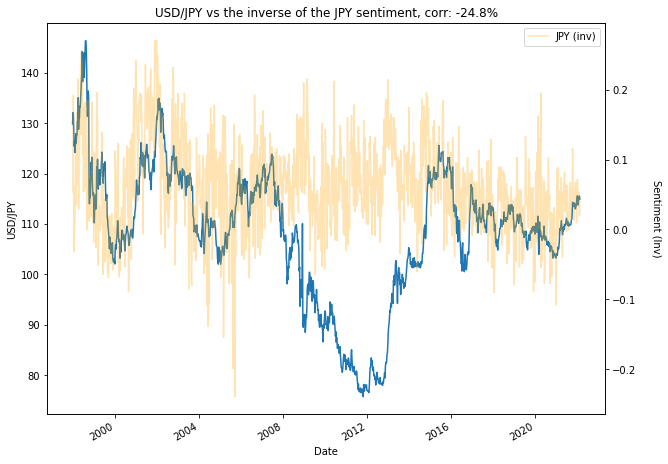

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
combined_df["Open"].plot(ax=ax)
ax.set_ylabel("USD/JPY")
ax.grid(False)
ax.set_title(f"USD/JPY vs the inverse of the JPY sentiment, corr: \
{combined_df[['LogRet','sentiment_JPY']].corr()['LogRet'].iloc[1]:.1%}")

ax2 = ax.twinx()
(-1*combined_df["sentiment_JPY"]).plot(ax=ax2, color='orange', alpha=0.3, 
                                       label="JPY (inv)")
ax2.grid(False)
ax2.set_ylabel("Sentiment (Inv)", rotation=270, labelpad=25)
ax2.legend()
plt.show()

In [8]:
features = ['LogRet', 'Vol', "sentiment_JPY"]
label_index = 0 # Thus LogRet

combined_df = combined_df[features]

### 2.2 In-sample and Out-of-sample
The in-sample period runs from Jan-1998 to Dec-2018.
The period from 2019 onwards is left as out-of-sample to be run only once the parameters of the model have been fully determined.

In [9]:
combined_is = combined_df['1998':'2018'].fillna(0).copy()
combined_os = combined_df['2019':].fillna(0).copy()

In [10]:
def split_sequences(sequences, n_steps):
    # From https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Choose number of timesteps for every training instance
n_steps = 1
X_train, y_train = split_sequences(combined_is.fillna(0).to_numpy(), n_steps)
X_test, y_test = split_sequences(combined_os.fillna(0).to_numpy(), n_steps)

# Selects label column
y_train = y_train[:, label_index]
y_test  = y_test[:, label_index]

### 2.3 Model parameters

Below we create a class to hold the LSTM configurations.

In [11]:
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold

# Creates an ouptut directory for holding results and temp models
ROOT_DIR = "."
folder_name = 'output'
if not os.path.exists(folder_name):
    os.makedirs(os.path.join(ROOT_DIR, folder_name))
OUT_DIR = os.path.join(ROOT_DIR, folder_name)

@dataclass
class MarketPsychLSTM(object):

  # Network settings
  nunits      = 100
  nlayers     = 1
  dropout     = 0.2
  activation  = 'tanh'
  loss        = 'mse'
  optimizer   = 'adam'

  # Early stop settings
  es_monitor  = 'val_loss'
  es_mode     = 'min'
  es_patience = 50
  es_verbose  = 0
  mc_filename = 'best_model.h5'

  # Fit settings
  epochs      = 1000
  batch_size  = 64
  verbose     = 0
  shuffle     = False
    
  def _build_network(self, X):
      # Sequential groups a linear stack of layers
      model = Sequential()
      if self.nlayers == 0:
          raise ValueError('Number of layers must be at least 1')
      elif self.nlayers == 1:
          model.add(LSTM(self.nunits))
      else:
          for layer in range(self.nlayers-1):
              # Default activation is tanh
              model.add(LSTM(self.nunits, activation=self.activation, 
                              return_sequences=True, 
                              input_shape=(X.shape[1], X.shape[2])))
              # Dropout is a technique where randomly selected neurons 
              # are ignored during training.
              model.add(Dropout(self.dropout))
          # Add last hidden layer
          model.add(LSTM(self.nunits))
      # Output layer
      model.add(Dense(1))
      model.compile(loss=self.loss, optimizer=self.optimizer)
      # Creates object with model
      self.model = model
      
  def _early_stopping(self):
      # Early stopping configuration
      es = EarlyStopping(monitor=self.es_monitor, mode=self.es_mode, 
                              verbose=0, patience=self.es_patience)
      mc = ModelCheckpoint(os.path.join(OUT_DIR, self.mc_filename), 
                            monitor=self.es_monitor, mode=self.es_mode, 
                            verbose=0, save_best_only=True)
      return es, mc
  
  def fit(self, X, y, val=None):
      self._build_network(X)
      # Fit network
      if val is not None:
          es, mc = self._early_stopping()
          callbacks = [es, mc]
      else:
          callbacks = None
      history = self.model.fit(X, y, epochs=self.epochs, 
                                batch_size=self.batch_size, 
                                use_multiprocessing=True,
                                validation_data=val,
                                verbose=self.verbose, 
                                shuffle=self.shuffle,
                                callbacks=callbacks)
      self.history = history
      if val is not None:
          self.model = load_model(os.path.join(OUT_DIR, self.mc_filename))

  def predict(self, X):
      return self.model.predict(X)
      
  def fit_kfold(self, X, y, num_folds=5, kfold_verbose=1):
      # Builds network
      self._build_network(X)
      # Define containers
      mse_per_fold  = []
      opt_n_epochs  = []
  
      # Series with predictions in the validation set
      valid_series  = pd.Series([], dtype='float64')
      # Define the K-fold Cross Validator
      kfold = KFold(n_splits=num_folds, shuffle=False)
      
      es, mc = self._early_stopping()
      fold_no = 1
      for train, valid in kfold.split(X, y):
          if kfold_verbose:
              # Generate a print
              print('----------------------------')
              print(f'Training fold {fold_no} ...')
          # Fit network
          history = self.model.fit(X[train], y[train],
                                    epochs=self.epochs, 
                                    batch_size=self.batch_size, 
                                    use_multiprocessing=True,
                                    validation_data=(X[valid], 
                                                    y[valid]), 
                                    verbose=self.verbose, 
                                    shuffle=False, callbacks=[es, mc])
          
          # Load the saved model
          saved_model = load_model(os.path.join(OUT_DIR, self.mc_filename))
          self.model = saved_model
          opt_epochs = len(history.history['val_loss'])
          opt_n_epochs.append(opt_epochs)
          if kfold_verbose:
              print(f'Epochs used: {opt_epochs}')

          scores = saved_model.evaluate(X[valid], y[valid], verbose=0)
          if kfold_verbose:
              print('RMSE for fold {:d}: {:>7.4}'.format(fold_no, 
                                                            np.sqrt(scores)))
          mse_per_fold.append(scores)
          
          temp_sr = pd.Series(np.squeeze(saved_model.predict(X[valid])), 
                              index=valid)
          valid_series = pd.concat([valid_series, temp_sr])

          # Increase fold number
          fold_no = fold_no + 1

      mse_per_fold = np.array(mse_per_fold)
      if kfold_verbose:
          print('Avg. RMSE: {:>7.4f}'.format(np.sqrt(mse_per_fold).mean()))
      return mse_per_fold, opt_n_epochs, valid_series

def plot_lstm_history(history, init_step=0):
    # Plot history
    for key in history.history.keys():
        plt.plot(history.history[key][init_step:], label=key)
    plt.xlabel('# epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

To determine the hyperparameters for this example, we run a KFold cross-validation with 5 combinations of in-sample/validation while varying the following variables:
 - number of units in each hidden layer: `5, 10 or 15`
 - number of hidden layers: `1 or 2`
 - activation function: `relu or tanh`

Obviously, this is not exhaustive, but it takes into account some level of optimization in some of the most revelant aspecs of a deep learning model. Other parameters have been defined as instances of the class defined above. It is also important to note that neural network models are stochastic. We thus seed the cells below and results should be reproducible. However, it is still possible that a different seed could yield somewhat different results.

Please run the following cell for obtaining the results of the cross-validation. Note this is somewhat computationally intense and as a result may take several minutes.

In [12]:
seed = 52

tf.keras.utils.set_random_seed(seed)

model = MarketPsychLSTM()
model.es_patience = 50
model.batch_size = len(X_train)
model.epochs  = 500

rmse_results = []
for nunits in [5, 10, 15]:
  for nlayers in [1, 2]:
    for activation in ['relu', 'tanh']:
      model.nunits  = nunits
      model.nlayers =  nlayers
      model.activation = activation

      # Runs a few times due to the stochastic character of the model
      mse_folds, _, _ = model.fit_kfold(X_train, y_train, kfold_verbose=0)

      mean_rmse = np.mean(np.sqrt(np.array(mse_folds)))
      temp_tup = ({"nunits":nunits, 
                   "nlayers":nlayers, 
                   "activation":activation}, 
                  mean_rmse)
      print(temp_tup)
      rmse_results.append(temp_tup)

({'nunits': 5, 'nlayers': 1, 'activation': 'relu'}, 0.01663785536546748)
({'nunits': 5, 'nlayers': 1, 'activation': 'tanh'}, 0.01668926816316418)
({'nunits': 5, 'nlayers': 2, 'activation': 'relu'}, 0.016741707130268048)
({'nunits': 5, 'nlayers': 2, 'activation': 'tanh'}, 0.016760813684205313)
({'nunits': 10, 'nlayers': 1, 'activation': 'relu'}, 0.01667208640744207)
({'nunits': 10, 'nlayers': 1, 'activation': 'tanh'}, 0.016647067293653412)
({'nunits': 10, 'nlayers': 2, 'activation': 'relu'}, 0.01677791283503436)
({'nunits': 10, 'nlayers': 2, 'activation': 'tanh'}, 0.016682486688669652)
({'nunits': 15, 'nlayers': 1, 'activation': 'relu'}, 0.01666932638428261)
({'nunits': 15, 'nlayers': 1, 'activation': 'tanh'}, 0.016647998046582523)
({'nunits': 15, 'nlayers': 2, 'activation': 'relu'}, 0.01652475798077065)
({'nunits': 15, 'nlayers': 2, 'activation': 'tanh'}, 0.01676547437097741)


Based on the above results, the lowest average RMSE for the 5 validation folds was obtained with the second last configuration (they are defined in the below cell).


In [13]:
model.nunits  = 15
model.nlayers =  2
model.activation = "relu"

## 3. Results

With the model being fixed, we now look at how to transform the obtained results into an actionable strategy.

For simplicity, we aim at a strategy with the following characteristics:  
 - possible allocations are only 100% long or 100% short the USD/JPY pair.
 - trading costs were set as 5 basis points.

To confirm the model is outputting reasonable results, we first use the validation results obtained during the training as a test case. 

The function below adds some trading related properties to the combined dataframe.

In [14]:
def add_properties(df, yhat, tc=0.0005):
  """"""
  # Appends prediction to dataframe
  df['yhat'] = np.insert(yhat.values, 0, 0)
  # Whether to go long or short based on the sign of the predicted change
  df["Position"] = np.sign(df["yhat"])
  # Return of the strategy based on the sign of the prediction
  df["yhatRet"] = df["Position"] * df["LogRet"]
  # Adds trading cost column and assign a value for when there is a trade
  df["TradingCost"] = 0
  df.loc[df["Position"] != df["Position"].shift(), "TradingCost"] = tc
  # Subtracts trading costs from returns
  df["MyLogRet"] = df["yhatRet"] - df["TradingCost"]
  return df

# Reruns the model with the chosen configuration
tf.keras.utils.set_random_seed(seed)
_, _, yhat_train = model.fit_kfold(X_train, y_train, kfold_verbose=0)
combined_is = add_properties(combined_is, yhat_train)
combined_is.head()

,LogRet,Vol,sentiment_JPY,yhat,Position,yhatRet,TradingCost,MyLogRet
Date,,,,,,,,
1998-01-05,0.017102,0.009313,-0.053045,0.000000,0.0,0.000000,0.0005,-0.000500
1998-01-12,-0.004628,0.010648,-0.192206,-0.002123,-1.0,0.004628,0.0005,0.004128
1998-01-19,-0.021291,0.014092,-0.025314,0.001458,1.0,-0.021291,0.0005,-0.021791
1998-01-26,-0.025812,0.012958,0.031825,0.002268,1.0,-0.025812,0.0000,-0.025812
1998-02-02,0.008019,0.010019,0.000278,0.001856,1.0,0.008019,0.0000,0.008019


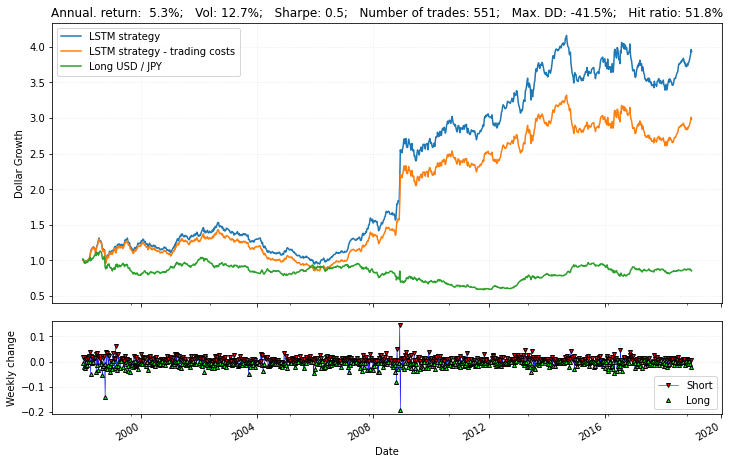

In [15]:
def max_drawdown(rets_sr):
    """
    Calculates maximum drawdown from all-time high.
    ...
    
    Parameters
    ----------
    rets_sr : pd.Series
        Series with period returns of the strategy.

    Returns
    ---------
        float
    """
    
    # Computes a "price" series based on returns
    price_sr = (rets_sr + 1).cumprod()
    # Computes maximum "price"
    roll_max = price_sr.expanding(min_periods=1).max()
    # Computes distance to all-time high at all points
    drawdown = price_sr / roll_max - 1
    
    return drawdown.min()

def plot_model_results(df, n_periods=52):
  """Display predicted returns and equity curve"""
  fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

  plt.subplots_adjust(hspace=0.1)
  np.exp(df.yhatRet.cumsum()).plot(ax=ax, label="LSTM strategy")
  np.exp(df.MyLogRet.cumsum()).plot(ax=ax, label="LSTM strategy - trading costs")
  np.exp(df.LogRet.cumsum()).plot(ax=ax, label="Long USD / JPY")
  ax.legend()
  ax.grid(alpha=0.3, ls=":")
  ax.set_ylabel("Dollar Growth")
  ax.set_title(f"Annual. return: {np.exp(df.MyLogRet.mean())**n_periods - 1: .1%}; \
  Vol: {(np.exp(df.MyLogRet) - 1).std() * np.sqrt(n_periods):.1%}; \
  Sharpe: {(np.exp(df.MyLogRet) - 1).mean() / (np.exp(df.MyLogRet) - 1).std() * np.sqrt(n_periods):.1f}; \
  Number of trades: {(df['TradingCost'] > 0).sum()}; \
  Max. DD: {max_drawdown(df.MyLogRet):.1%}; \
  Hit ratio: {df.MyLogRet.gt(0).sum() / len(df):.1%}")

  df.LogRet.plot(ax=ax2, c='b', lw=0.5, label="Short",
          marker="v",
          markersize=4,
          markerfacecolor='red',
          markeredgecolor='k',
          markevery=list(np.where((df.Position.shift(-1) < 0), True, False)))
  df.LogRet.plot(ax=ax2, c='b', lw=0, label="Long",
          marker="^",
          markersize=4,
          markerfacecolor='lime',
          markeredgecolor='k',
          markevery=list(np.where((df.Position.shift(-1) > 0), True, False)))
  ax2.set_ylabel('Weekly change')
  ax2.grid(alpha=0.3, ls=":")
  ax2.legend()

  plt.show()

plot_model_results(combined_is)

### 3.1 Out-of-sample
Results from the validation periods are reasonable and we now proceed with testing the last applied model with the unseen data in the out-of-sample set. The results for that period can be seen below.

,LogRet,MyLogRet
count,164.000000,164.000000
mean,0.000251,0.001283
std,0.009419,0.009211
min,-0.035701,-0.036201
25%,-0.004876,-0.004117
50%,0.000743,0.001057
75%,0.006488,0.006956
max,0.035260,0.034185



Count of positions


 1.0    111
-1.0     52
 0.0      1
Name: Position, dtype: int64

Number of trades: 82


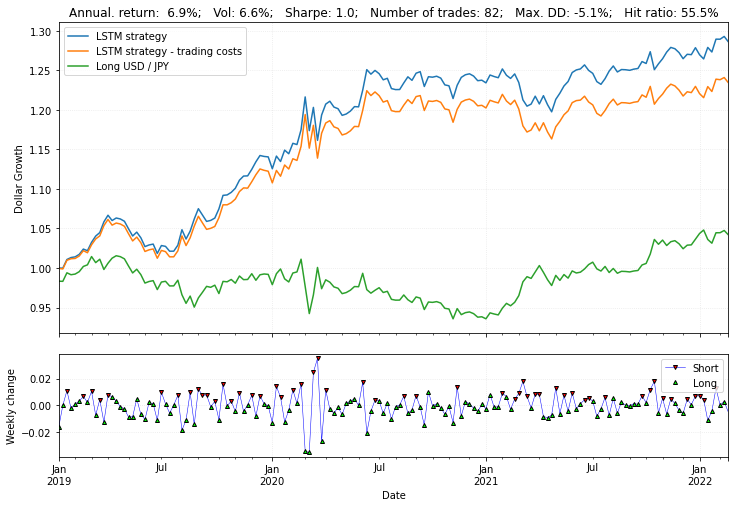

In [16]:
tf.keras.utils.set_random_seed(seed)
yhat_test = model.predict(X_test)
combined_os = add_properties(combined_os, pd.Series(yhat_test.flatten()))

display(combined_os[["LogRet", "MyLogRet"]].describe())
print()
print("Count of positions")
display(combined_os.Position.value_counts())

print("Number of trades:", (combined_os["TradingCost"] > 0).sum())

plot_model_results(combined_os)

## 4. Discussion

As seen above, the model also performs well in the out-of-sample period, although volatility has been lower than in the period used as in-sample. As the trading arrows in the lower subplot seem to indicate, the model often bets on the mean reversion. To better understand the relation between prior returns, sentiment, and the prediction we use the SHAP tool to analyse the model.

Instructions for updating:
non-resource variables are not supported in the long term


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


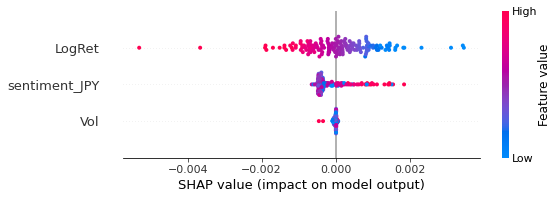

In [17]:
# SHAP not currently working with TF >2.5, so we adjust 
# and retrain
tf.compat.v1.disable_v2_behavior()
# Reruns the model with the chosen configuration
tf.keras.utils.set_random_seed(seed)
model.fit(X_train, y_train)

import shap
explainer = shap.DeepExplainer(model.model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.summary_plot(shap_values[0].reshape(shap_values[0].shape[0], 3), 
                  X_test.reshape(X_test.shape[0], 3), features)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

As seen above, indeed negative changes in the USD/JPY rate have a positive impact on the model (with respect to the sign of the prediction) and vice-versa. However, we can also see that sentiment acts on the opposite direction. High values of JPY sentiment have a positive impact on the model ouptut. 

## 5. Conclusions

In this example, we trained a long short-term memory (LSTM) network for predicting the one-week ahead change in the USD/JPY rate. The model, which uses price data in combination with the Refinitiv MarketPsych Analytics (RMAs) data, yields positive returns in the out-of-sample period. As we have shown here, RMAs are easy-to-deploy time-series that can be applied straighforwardly as extra features in statistical and machine learning-based algorithms. 